## **LangGraph Tutorial: Building a Text Analysis Pipeline**

### **Introduction to LangGraph**

LangGraph is a powerful framework by LangChain designed for creating stateful, multi-actor applications with LLMs. It provides the structure and tools needed to build sophisticated AI agents through a graph-based approach.

Think of LangGraph as an architect's drafting table -  it gives us the tools to design how our agent will think and act. Just as an architect draws blueprints showing how different rooms connect and how people will flow through a building, LangGraph lets us design how different capabilities will connect and how information will flow through our agent.

#### **Key Features:**
- **State Management**: Maintain persistent state across interations
- **Flexible Routing**: Define complex flows between components
- **Persistence**: Save and resume workflows
- **Visualization**: See and understand your agent's structure

In this tutorial, we'll demonstrate LangGraph by building a multi-step text analysis pipeline that processes text through 3 stages:
1. **Text Classification:** Categorize input text into predefined categories
2. **Entity Extraction:** Identify key entities from the text
3. **Text Summarization:** Generate a concise summary of the input text

### **Setting Up Enviroment**

#### Install required packages

In [93]:
!pip install -q -q -q langgraph langchain langchain-google-genai python-dotenv

#### Setting Up API Keys

In [94]:
import os
from dotenv import load_dotenv

# Load env variables from a .env file
load_dotenv()

# Set the API keys as environment variables
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

#### Testing Setup

In [95]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the ChatGoogleGenerativeAI instance
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Test the setup
response = llm.invoke("Hi, how are you?")
print(response.content)

Hi! I'm doing great, thank you for asking!

How about you? How are you doing today?


### **Building Text Analysis Pipeline**

In [96]:
import os
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

#### **Designing Agent's Memory**

Just as human intelligence requires memory, our agent needs a way to keep track of information. We create this using a TypedDict to define our state structure

In [97]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

# Initialize the LLM instance with temperature = 0 for deterministic outputs
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

#### **Creating Agent's Core Capabilities**

Now we'll create the actual skills of agent will use. Each of these capabilities is implemented as a function that performs a specific type of analysis.

##### **Define agent's capabilities**

In [114]:
# 1. Classification Node
def classification_node(state: State):
    '''Classify the text into categories like: News, Blog, Research, or Other.'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of these categories: News, Blog, Research, or Other. Just pure text\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    
    return {"classification": classification}

In [115]:
# 2. Entity Extraction Node
def entity_extraction_node(state: State):
    '''Extract all the entities (Person, Organization, Location) from the text'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location, or a specific entity) from the following text. Just pure text. Provide the result as a comma-seperated list.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    
    return {"entities": entities}

In [116]:
# 3. Summarization Node
def summarization_node(state: State):
    '''Summarize the text in a short sentence'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

##### **Bring all the capabilities together**

In [118]:
# Create StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification")
workflow.add_edge("classification", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

##### **Visualizing the Workflow**

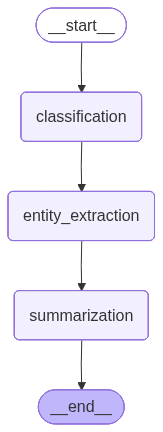

In [102]:
try:
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API
            )
        )
    )
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("The graph structure is: classification -> entity_extraction -> summarization -> END")

### **Testing Agent**

In [119]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
Additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("Entities:", result["entities"])
print("Summary:", result["summary"])

Classification: News
Entities: ['OpenAI', 'GPT-4', 'GPT-3']
Summary: OpenAI has announced GPT-4, a powerful new multimodal AI model with human-level performance and enhanced safety, due for release soon.


### **Understanding the Power of Coordinated Processing**

What makes this result particularly impressive isn't just the individual outputs - it's how each step build on the others to create a complete understanding of the text.
- The **classification** provides context that helps frame understanding of the text type
- The **entity extraction** identifies important names and concepts
- The **summarization** distills the essence of the document

This mirrors human reading comprehension, where we naturally from an understading of that kind of text it is, note important names and concepts, and form a mental summary - all while maintaining the relationships between these different aspects of understanding.

#### **Try with another text**

In [104]:
text = """
The recent advancements in quantum computing have opened new possibilities for cryptography and data security. 
Researchers at MIT and Google have demonstrated quantum algorithms that could potentially break current encryption methods.
However, they are also developing new quantum-resistant encryption techniques to protect data in the future.
"""

state_input = {"text": text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("Entities:", result["entities"])
print("Summary:", result["summary"])

Classification: Category: News
Entities: ['MIT', 'Google']
Summary: Quantum computing advancements threaten current encryption but are also driving the development of new, quantum-resistant security solutions.


### **Adding More Capabilities (Advanced)**

One of the powerful aspects of LangGraph is how easily we can extend our agent with new capabilities. Let's add a sentiment analysis node to our pipeline:

In [120]:
# Update State to include sentiment
class EnhancedState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
    sentiment: str

In [124]:
# Create sentiment analysis node
def sentiment_node(state: EnhancedState):
    '''Analyze the sentiment of the text: Positive, Negative or Neutral'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Analyze and explain the sentiment of the following text. Just pure text, don't markdown. Is it Positive, Negative or Neutral?\n\nText:{text}\n\nSentiment:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    sentiment = llm.invoke([message]).content.strip()
    return {"sentiment": sentiment}

In [125]:
# Create a new workflow with the enhanced state
enhanced_workflow = StateGraph(EnhancedState)

enhanced_workflow.add_node("classification", classification_node)
enhanced_workflow.add_node("entity_extraction", entity_extraction_node)
enhanced_workflow.add_node("summarization", summarization_node)
enhanced_workflow.add_node("sentiment_analysis", sentiment_node)

enhanced_workflow.set_entry_point("classification")
enhanced_workflow.add_edge("classification", "entity_extraction")
enhanced_workflow.add_edge("entity_extraction", "summarization")
enhanced_workflow.add_edge("summarization", "sentiment_analysis")
enhanced_workflow.add_edge("sentiment_analysis", END)

# Compile the enhanced graph
enhanced_app = enhanced_workflow.compile()

##### **Testing the enhanced Agent**

In [126]:
enhanced_result = enhanced_app.invoke(state_input)

print("Classification:", enhanced_result["classification"])
print("Entities:", enhanced_result["entities"])
print("Summary:", enhanced_result["summary"])
print("Sentiment:", enhanced_result["sentiment"])

Classification: News
Entities: ['OpenAI', 'GPT-4', 'GPT-3']
Summary: OpenAI has announced GPT-4, a powerful new multimodal AI model with human-level performance and enhanced safety, due for release soon.
Sentiment: Positive


### **Adding Conditional Edges to the LangGraph Pipeline (Advanced Logic)**

#### Why **Conditional Edges?**

So far, our graph has followed a fixed linear path:

classification -> entity_extraction -> summarization -> sentiment

But in real-world applications, we often want to run certain steps only if needed. For example:
- Only extract entities if the text is a News or Research article.
- Skip the summarization if the text is very short.
- Add custom processing for Blog posts.

LangGraph makes this easy through conditional edges-logic gates that dynamically route excution based on data in the current state.

#### **1. Update the State**

In [127]:
class EnhancedState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
    sentiment: str

#### **2. Create a Routing Function**

This function routes based on classification

In [128]:
# Route after classification
def route_after_classification(state: EnhancedState) -> str:
    category = state["classification"].lower()
    return category in ["news", "research"]

#### **3. Define the Graph**

In [129]:
conditional_workflow = StateGraph(EnhancedState)

conditional_workflow.add_node("classification", classification_node)
conditional_workflow.add_node("entity_extraction", entity_extraction_node)
conditional_workflow.add_node("summarization", summarization_node)
conditional_workflow.add_node("sentiment_analysis", sentiment_node)

conditional_workflow.set_entry_point("classification")
conditional_workflow.add_conditional_edges("classification", route_after_classification, path_map={
    True: "entity_extraction",
    False: "summarization"
})
conditional_workflow.add_edge("entity_extraction", "summarization")
conditional_workflow.add_edge("summarization", "sentiment_analysis")
conditional_workflow.add_edge("sentiment_analysis", END)

conditional_app = conditional_workflow.compile()

#### **4. Visualize**

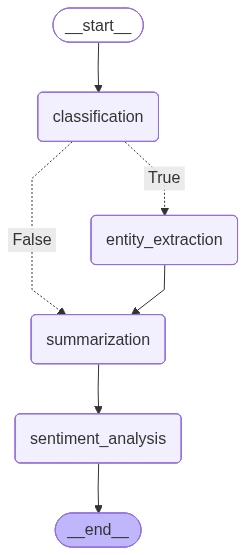

In [130]:
try:
    display(
        Image(
            conditional_app.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print("Graph: classification_node → (conditional) → [entity_extraction or summarization] → sentiment_analysis → END")

#### **5. Test the conditional Pipeline**

In [131]:
test_text = """
OpenAI released the GPT-4 model with enhanced performance on academic and professional tasks. It's seen as a major breakthrough in alignment and reasoning capabilities.
"""

result = conditional_app.invoke({"text": test_text})

print("Classification:", result["classification"])
print("Entities:", result.get("entities", "Skipped"))
print("Summary:", result["summary"])
print("Sentiment:", result["sentiment"])

Classification: News
Entities: ['OpenAI', 'GPT-4']
Summary: OpenAI's GPT-4 model offers enhanced performance on tasks and represents a major breakthrough in AI alignment and reasoning.
Sentiment: Positive
The text uses words like "enhanced performance" and "major breakthrough," which convey significant improvement and achievement. These terms indicate a highly favorable view of the GPT-4 model's release and capabilities. There are no negative or neutral descriptors that would balance out this positive language.


In [133]:
# Try blog type
blog_text = """
Here's what I learned from a week of meditating in silence. No phones, no talking—just me, my breath, and some deep realizations.
"""

result = conditional_app.invoke({"text": blog_text})

print("Classification:", result["classification"])
print("Entities:", result.get("entities", "Skipped (not applicable)"))
print("Summary:", result["summary"])
print("Sentiment:", result["sentiment"])

Classification: Blog
Entities: Skipped (not applicable)
Summary: A week of silent, distraction-free meditation led to deep personal realizations.
Sentiment: Positive. The text describes an experience of learning and gaining "deep realizations" from silent meditation. These phrases indicate a beneficial and insightful outcome, suggesting personal growth and a valuable experience.


With conditional edges, our agent can now:
- Make decisions based on context
- Skip unnecessary steps
- Run faster and cheaper
- Behave more intelligently

### **Conclusion**

In this tutorial, we've:
1. Explored LangGraph concepts and its graph-based approach
2. Built a text processing pipeline with classification, entity extraction, and summarization
3. Enhanced our pipeline with additional capabilities
4. Introduced conditional edges to dynamically control the flow based on classification results
5. Visualized our workflow
6. Tested our agent with real-world text examples

LangGraph provides a powerful framework for creating AI agents by modeling them as graphs of capabilities. This approach makes it easy to design, modify and extend complex AI systems.

#### **Next Steps**
- Add more nodes to extend agent's capabilities
- Experiment with different LLMs and parameters
- Explore LangGraph's state persistence features for ongoing conversations